In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('imdb.csv')

In [3]:
df=df.drop(['No_of_Votes', 'Gross', 'Meta_score'],axis=1)

In [4]:
df.head(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Director,Star1,Star2,Star3,Star4
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler


In [5]:
df.isnull().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
dtype: int64

In [6]:
df.shape

(1000, 13)

# Data Visualization

In [7]:
import wordcloud
from wordcloud import WordCloud,STOPWORDS

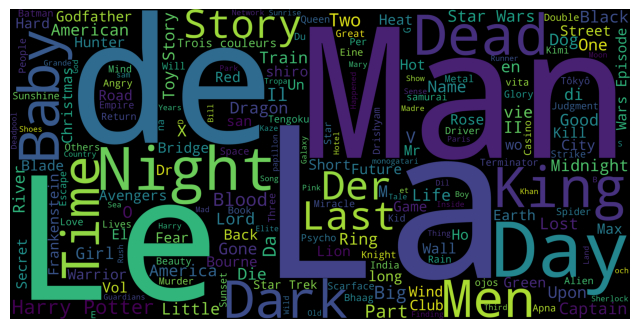

In [8]:
df['Series_Title'] = df['Series_Title'].fillna("").astype('str')
title_corpus = ' '.join(df['Series_Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(8,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

array([[<Axes: title={'center': 'IMDB_Rating'}>]], dtype=object)

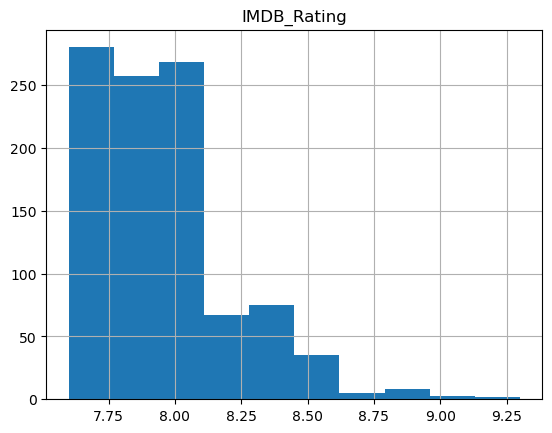

In [9]:
df.hist(column='IMDB_Rating')

# Genre Filter

In [10]:
genre_labels = set()
a=df['Genre'].str.split(',').values
b=df['Genre'].str.split(', ').values
c=df['Genre'].str.split(' ,').values
d=np.concatenate((np.concatenate((a, b), axis=0),c),axis=0)

for s in np.logical_and(a, b, c):
   genre_labels = genre_labels.union(set(s))

print(genre_labels)

{'Western', 'History', 'Biography', 'Fantasy', 'War', 'Sport', 'Thriller', 'Action', 'Animation', 'Crime', 'Mystery', 'Musical', 'Romance', 'Drama', 'Comedy', 'Sci-Fi', 'Music', 'Film-Noir', 'Horror', 'Family', 'Adventure'}


In [11]:
def count_word(df,Genre, census):

    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in np.logical_and(a, b, c):        
        if type(census_keywords) == int and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
   
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

keyword_occurences, dum = count_word(df, 'Genre', genre_labels)
keyword_occurences[:]


[['Drama', 724],
 ['Comedy', 233],
 ['Crime', 209],
 ['Adventure', 196],
 ['Action', 189],
 ['Thriller', 137],
 ['Romance', 125],
 ['Biography', 109],
 ['Mystery', 99],
 ['Animation', 82],
 ['Sci-Fi', 67],
 ['Fantasy', 66],
 ['History', 56],
 ['Family', 56],
 ['War', 51],
 ['Music', 35],
 ['Horror', 32],
 ['Western', 20],
 ['Sport', 19],
 ['Film-Noir', 19],
 ['Musical', 17]]

In [12]:
df['Genre'] = df['Genre'].fillna("").astype('str')
print(type(df['Genre']))

<class 'pandas.core.series.Series'>


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['Genre'])
tfidf_matrix.shape

(1000, 132)

In [14]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.32753693, 0.2090213 , 0.32753693],
       [0.32753693, 1.        , 0.63816101, 1.        ],
       [0.2090213 , 0.63816101, 1.        , 0.63816101],
       [0.32753693, 1.        , 0.63816101, 1.        ]])

In [15]:
# Build a 1-dimensional array with movie titles
titles = df['Series_Title']
indices = pd.Series(df.index, index=df['Series_Title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    if title in titles.values:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:50]
        movie_indices = [i[0] for i in sim_scores]
        name2 = titles.iloc[movie_indices]
        return name2

    dff = df[df['Series_Title'].str.contains(title)]
    x=dff['Series_Title'].iloc[0]
    y=genre_recommendations(x)
    return y

In [16]:
genre_recommendations('Harry Potter').head(10)

226    Harry Potter and the Deathly Hallows: Part 2
377                                        Big Fish
497                                        The Fall
498                                      Life of Pi
537                              La montaña sagrada
964                                        Dead Man
292                           El ángel exterminador
25                                   The Green Mile
487                          Låt den rätte komma in
762                           Death Note: Desu nôto
Name: Series_Title, dtype: object

In [17]:
from sklearn.utils import shuffle
genres = df['Series_Title']
indices = pd.Series(df.index, index=df['Series_Title'])

def genre_genre_recommendations(genre):
    dfg = df[df['Genre'].str.contains(genre)]
    dfg=shuffle(dfg)
    x=dfg['Series_Title']
    return x

In [18]:
genre_genre_recommendations('Fantasy').head(10)

643                                     Waking Life
799              South Park: Bigger, Longer & Uncut
624                                      Mr. Nobody
755    Harry Potter and the Deathly Hallows: Part 1
593                                      About Time
568                                       Nosferatu
758                                        Papurika
29                                        Star Wars
292                           El ángel exterminador
557                                          Harvey
Name: Series_Title, dtype: object

# Movie Filter

In [19]:
df['Series_Title'] = df['Series_Title'].fillna("").astype('str')

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf_vectorizer = TfidfVectorizer ()
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['Series_Title'])
tfidf_matrix.shape

(1000, 2544)

In [21]:
from sklearn.metrics.pairwise import linear_kernel
cosine = linear_kernel(tfidf_matrix,tfidf_matrix)
#cosine[:5,:5]

In [22]:
titles = df['Series_Title']
indices = pd.Series(df.index, index=df['Series_Title'])
df2 = titles.to_frame()

def movie_recommendations(title):
    if title in titles.values:
        idx = indices[title]
        sim_scores = list(enumerate(cosine[idx]>0.0))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        aa=[f[1] for f in sim_scores]
        b=aa.count(True)
        sim_scores = sim_scores[0:b]
        movie_indices = [i[0] for i in sim_scores]
        name2 = titles.iloc[movie_indices]
        return name2

    dff = df[df['Series_Title'].str.contains(title)]
    name = dff['Series_Title']
    return name 

In [23]:
movie_recommendations('Harry')

226    Harry Potter and the Deathly Hallows: Part 2
506        Harry Potter and the Prisoner of Azkaban
755    Harry Potter and the Deathly Hallows: Part 1
781             Harry Potter and the Goblet of Fire
853                                     Dirty Harry
927          Harry Potter and the Half-Blood Prince
947           Harry Potter and the Sorcerer's Stone
975                         When Harry Met Sally...
Name: Series_Title, dtype: object

In [24]:
movie_recommendations('12 Angry Men')

4                    12 Angry Men
215              12 Years a Slave
232        No Country for Old Men
336                 Short Term 12
479    X-Men: Days of Future Past
513               Children of Men
536       All the President's Men
794     Hedwig and the Angry Inch
824                A Few Good Men
Name: Series_Title, dtype: object

# Director Filter

In [25]:
def director_recommendations(Director):
    dd = df[df['Director'].str.contains(Director)]
    return set(dd['Series_Title'])

In [26]:
director_recommendations('Nolan')

{'Batman Begins',
 'Dunkirk',
 'Inception',
 'Interstellar',
 'Memento',
 'The Dark Knight',
 'The Dark Knight Rises',
 'The Prestige'}

# Rating Filter

In [27]:
from sklearn.utils import shuffle
genres = df['Series_Title']
indices = pd.Series(df.index, index=df['Series_Title'])


def genre_rating_recommendations(genre):
    dd = df
    dd['IMDB_Rating'] = dd['IMDB_Rating'].apply(math.floor)
    df3 = dd['IMDB_Rating']
    dfg = df[df['Genre'].str.contains(genre)]
    dfg.insert(1,'Rating',df3)
    dfg = shuffle(dfg)
    dfg = dfg.sort_values('Rating', ascending = False, ignore_index = True)
    x=dfg['Series_Title']
    return x

In [28]:
genre_rating_recommendations('Musical')

0                                      PK
1                      Dancer in the Dark
2                     Munna Bhai M.B.B.S.
3       Lagaan: Once Upon a Time in India
4                     Fiddler on the Roof
5                     Singin' in the Rain
6                           Kal Ho Naa Ho
7                                   Anand
8                                 Cabaret
9                                Rockstar
10                          All That Jazz
11                   A Night at the Opera
12                           My Fair Lady
13                     A Hard Day's Night
14                             Veer-Zaara
15                              Duck Soup
16    Willy Wonka & the Chocolate Factory
Name: Series_Title, dtype: object

# Actor Filter

In [29]:
aa = df[['Star1','Star2','Star3','Star4']]
def actors_recommendations(Actor):
    dd = df[aa.apply(lambda row: any(Actor in str(cell) for cell in row), axis=1)]
    dd = shuffle(dd)
    return dd['Series_Title']

In [30]:
#val = input()
actors_recommendations('Paresh')

208             OMG: Oh My God!
129    Uri: The Surgical Strike
160                  Hera Pheri
20              Soorarai Pottru
Name: Series_Title, dtype: object

# Combine Filter

In [31]:
aa = df[['Star1','Star2','Star3','Star4']]
def actor_recommendations(Actor):
    dd = df[aa.apply(lambda row: any(Actor in str(cell) for cell in row), axis=1)]
    dd = shuffle(dd)
    s1 = set(dd['Series_Title'])
    return s1

def genre_rating_recommendations(genre):
    dd = df
    dd['IMDB_Rating'] = dd['IMDB_Rating'].apply(math.floor)
    df3 = dd['IMDB_Rating']
    dfg = df[df['Genre'].str.contains(genre)]
    dfg.insert(1,'Rating',df3)
    dfg = shuffle(dfg)
    dfg = dfg.sort_values('Rating', ascending = False, ignore_index = True)
    s2 = set(dfg['Series_Title'])
    return s2

def directors_recommendations(Director):
    dd = df[df['Director'].str.contains(Director)]
    s3 = set(dd['Series_Title'])
    return s3

def AGD(a,b,c):
    x= actor_recommendations(a)
    y= genre_rating_recommendations(b)
    z= directors_recommendations(c)
    movies = x.intersection(y).intersection(z)
    mov_new = sorted(movies)
    movies_new = pd.DataFrame([sub.split(',') for sub in mov_new])
    fillter = movies_new.to_string(header = False)
    return fillter

In [32]:
n = int(input("Enter No. of Actors: "))
m={}
w={}
y={}
if n != -1:
    x = input("Enter: ")
    m = actor_recommendations(x)

    for i in range(1,n):
        x = input("Enter: ")
        y = actor_recommendations(x)
        m = y.intersection(m)
        
n = int(input("Enter No. of Genres: "))

if n != -1:
    if m == {}:
        x = input("Enter: ")
        w = genre_rating_recommendations(x)
        for i in range(1,n):
            x = input("Enter: ")
            y = genre_rating_recommendations(x)
            w = y.intersection(w)
    else:
        for i in range(0,n):
            x = input("Enter: ")
            y = genre_rating_recommendations(x)
            m = y.intersection(m)

for i in range (0,1): 
    x = input("Enter Director: ")
    if x == '-1': 
        if m != {}:
            print(m)
        elif w != {}:
            print(w)
        else:
            print("Input not found")
    else:
        y = directors_recommendations(x)
        if m != {} and w == {}:
            y = y.intersection(m)
            print(y)
        elif m == {} and w != {}:
            y = y.intersection(w)
            print(y)
        else:
            print(y)

Enter No. of Actors: 2
Enter: Amita
Enter: Hema
Enter No. of Genres: 1
Enter: Family
Enter Director: -1
set()
